## Delta Method Analysis Tutorial
This notebook shows how the DeltaMethodAnalysis class is performing the Delta Method for a simple ratio metric. In this case the cluster column is going to be at user level for the current example.

We also compare the usage of CUPED in tandem with the Delta Method as a way to reduce variance.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from cluster_experiments.experiment_analysis import DeltaMethodAnalysis
from scipy.stats import norm

In [2]:
def generate_ratio_metric_data(
    N,
    num_users=2000,
    user_sample_mean=0.3,
    user_standard_error=0.15,
    treatment_effect=0.1,
) -> pd.DataFrame:

    user_sessions = np.random.choice(num_users, N)
    user_target_means = np.random.normal(
        user_sample_mean, user_standard_error, num_users
    )
    # assign treatment groups
    treatment = np.random.choice([0, 1], num_users)

    # create target rate per session level
    target_percent_per_session = (
        treatment_effect * treatment[user_sessions]
        + user_target_means[user_sessions]
        + np.random.normal(0, 0.01, N)
    )

    # Remove <0 or >1
    target_percent_per_session[target_percent_per_session > 1] = 1
    target_percent_per_session[target_percent_per_session < 0] = 0

    targets_observed = np.random.binomial(1, target_percent_per_session)

    # rename treatment array 0-->A, 1-->B
    mapped_treatment = np.where(treatment == 0, "A", "B")

    return pd.DataFrame(
        {
            "user": user_sessions,
            "treatment": mapped_treatment[user_sessions],
            "target": targets_observed,
            "scale": np.ones_like(user_sessions),
        }
    )

In [3]:
def compare_vanilla_cuped(N, num_users=2000, user_sample_mean=0.3, user_standard_error=0.5, treatment_effect=0.1):
    #data generation
    pre_data = generate_ratio_metric_data(N, num_users, user_sample_mean, user_standard_error, treatment_effect=0)
    post_data = generate_ratio_metric_data(N, num_users, user_sample_mean, user_standard_error, treatment_effect)
    

    pre_data['date']= pd.to_datetime('2022-01-01')
    post_data['date']= pd.to_datetime('2022-01-02')

    data = pd.concat([pre_data, post_data])
    analysis_vanilla = DeltaMethodAnalysis(
        cluster_cols=["user"]
    )
    vanilla_pval = analysis_vanilla.get_pvalue(post_data)

    analysis_cuped = DeltaMethodAnalysis(
        cluster_cols=["user"], cuped_time_split=("date", post_data['date'].min())
    )
    cuped_pval = analysis_cuped.get_pvalue(data)

    #naive t-test considering the same randomization unit at user level
    post_data= post_data.groupby(['user', 'treatment']).agg({'target':'sum', 'scale':'sum'}).reset_index()
    post_data['metric']  = post_data['target']/post_data['scale']
    stats = post_data.groupby('treatment').agg(
        mean = ('metric', 'mean'),
        var = ('metric', 'var'),
        num_samples = ('scale', 'sum')
        )

    mean_dif = stats.loc['A', 'mean'] - stats.loc['B', 'mean']
    var_dif = stats.loc['A', 'var']/stats.loc['A', 'num_samples'] + stats.loc['B', 'var']/stats.loc['B', 'num_samples']
    z_score = mean_dif/np.sqrt(var_dif)
    naive_user_pval = 2 * (1 - norm.cdf(abs(z_score)))

    #population naive t-test
    #it follows a test in proportions
    p1 = post_data.loc[post_data['treatment']=='A', 'target'].sum()/post_data.loc[post_data['treatment']=='A', 'scale'].sum()
    p2 = post_data.loc[post_data['treatment']=='B', 'target'].sum()/post_data.loc[post_data['treatment']=='B', 'scale'].sum()
    n1 = post_data[post_data['treatment']=='A'].shape[0]
    n2 = post_data[post_data['treatment']=='B'].shape[0]

    # SE
    SE = np.sqrt(p1*(1-p1)/n1 + p2*(1-p2)/n2)
    # z-score
    z = (p1 - p2) / SE
    # p-value
    naive_prop_pval2 = 2 * (1 - norm.cdf(abs(z)))


    return vanilla_pval, cuped_pval, naive_user_pval, naive_prop_pval2

### A-A test for validation

In [4]:
# Let's generate some fake switchback data (the clusters here would be city and date
N = 200_000

vanilla_p_values = []
cuped_p_values = []
naive_user_p_values = []
naive_prop_p_values = []
for _ in range(1000):
    delta_vanilla, delta_cuped, naive_user,naive_prop_pval2 = compare_vanilla_cuped(N, num_users = 5_000, treatment_effect= 0)
    vanilla_p_values.append(delta_vanilla)
    cuped_p_values.append(delta_cuped)
    naive_user_p_values.append(naive_user)
    naive_prop_p_values.append(naive_prop_pval2)

print(f"Naive average p-value test proportions: {np.mean(naive_prop_p_values)}")
print(f"Naive average p-value considering randomization unit: {np.mean(naive_user_p_values)}")
print(f"Delta Vanilla average p-value: {np.mean(vanilla_p_values)}")
print(f"Delta with CUPED average p-value: {np.mean(cuped_p_values)}")

Naive average p-value test proportions: 0.6149795233184215
Naive average p-value considering randomization unit: 0.12197408848474775
Delta Vanilla average p-value: 0.5203860652477394
Delta with CUPED average p-value: 0.523364963507627


In [5]:
positives_vanilla = sum([pval< 0.05 for pval in vanilla_p_values])
positives_cuped = sum([pval< 0.05 for pval in cuped_p_values])
positives_prop_ttest = sum([pval< 0.05 for pval in naive_prop_p_values])
positives_user_ttest = sum([pval< 0.05 for pval in naive_user_p_values])

print(f"Naive false positives rate test proportions: {positives_prop_ttest/len(naive_prop_p_values)}")
print(f"Naive false positives rate test with randomization unit: {positives_user_ttest/len(naive_user_p_values)}")
print(f"Delta Vanilla false positives rate: {positives_vanilla/len(vanilla_p_values)}")
print(f"Delta with CUPED false positives rate: {positives_cuped/len(cuped_p_values)}")

Naive false positives rate test proportions: 0.004
Naive false positives rate test with randomization unit: 0.739
Delta Vanilla false positives rate: 0.041
Delta with CUPED false positives rate: 0.04


#### Check p-val distributions

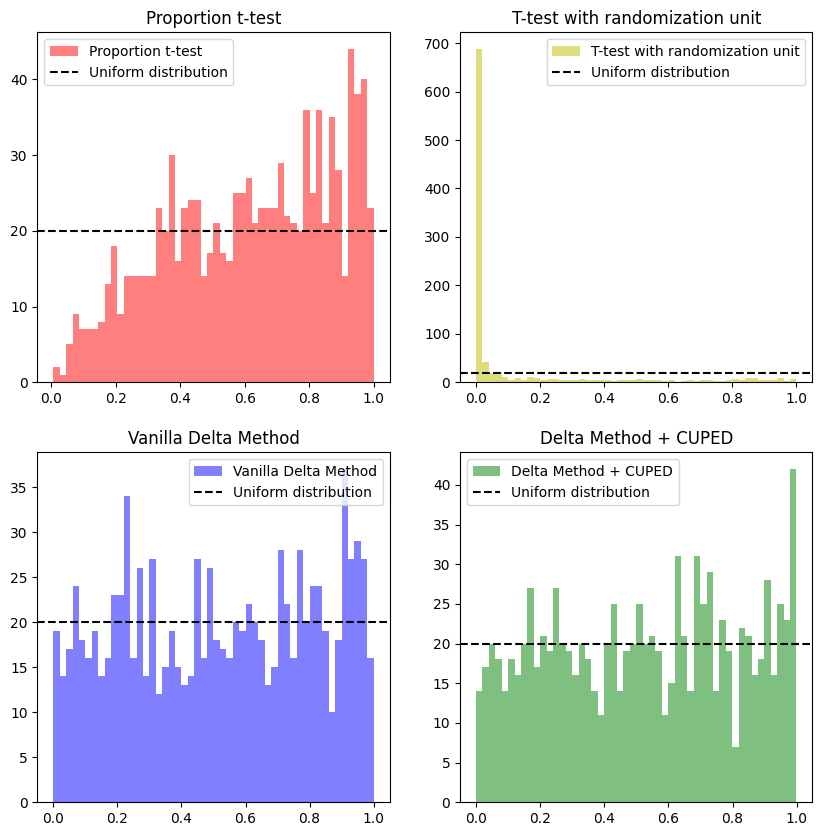

In [6]:
# Do a subfigure with four plots 2x2 of the p-values add also uniform distribution line
num_bins = 50
uniform_line = len(naive_prop_p_values)/num_bins

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0, 0].hist(naive_prop_p_values, bins=num_bins, alpha=0.5, label='Proportion t-test', color='r')
axs[0, 0].axhline(y=uniform_line, color='black', linestyle='--', label='Uniform distribution')
axs[0, 0].set_title('Proportion t-test')
axs[0, 0].legend()
axs[0, 1].hist(naive_user_p_values, bins=num_bins, alpha=0.5, label='T-test with randomization unit', color='y')
axs[0, 1].axhline(y=uniform_line, color='black', linestyle='--', label='Uniform distribution')
axs[0, 1].set_title('T-test with randomization unit')
axs[0, 1].legend()
axs[1, 0].hist(vanilla_p_values, bins=num_bins, alpha=0.5, label='Vanilla Delta Method', color='b')
axs[1, 0].axhline(y=uniform_line, color='black', linestyle='--', label='Uniform distribution')
axs[1, 0].set_title('Vanilla Delta Method')
axs[1, 0].legend()
axs[1, 1].hist(cuped_p_values, bins=num_bins, alpha=0.5, label='Delta Method + CUPED', color='g')
axs[1, 1].axhline(y=uniform_line, color='black', linestyle='--', label='Uniform distribution')
axs[1, 1].set_title('Delta Method + CUPED')
axs[1, 1].legend()
plt.show()

In the A/A test we should expect a distribution resembling a uniform distribution. As we can see unless we are using the Delta Method this is not the case. 

We can see that if one considers a standard test in proportions, the p-value distribution is shifted towards higher numbers of p-values. 
If now one considers the randomization unit (in this case user) we see that the p-values have a huge jump near zero. This is because the variance estimator is heavily underestimating it.
As one uses the Delta Method we see that one recover a uniform-like distribution which should be expected.


Note that a solution to these problems could be applying OLS with clustered errors. The advantage of the Delta Method lies in its performance as compared to OLS.

### Simulated-case comparison

Here we compare the naive t-test estimations vs the Delta Method with and without CUPED

In [7]:
# Let's generate some fake switchback data (the clusters here would be city and date
N = 200_000

vanilla_p_values = []
cuped_p_values = []
naive_user_p_values = []
naive_prop_p_values = []
for _ in range(1000):
    delta_vanilla, delta_cuped, naive_user,naive_prop_pval2 = compare_vanilla_cuped(N, num_users = 5_000, treatment_effect= 0.05)
    vanilla_p_values.append(delta_vanilla)
    cuped_p_values.append(delta_cuped)
    naive_user_p_values.append(naive_user)
    naive_prop_p_values.append(naive_prop_pval2)

print(f"Naive average p-value test proportions: {np.mean(naive_prop_p_values)}")
print(f"Naive average p-value considering randomization unit: {np.mean(naive_user_p_values)}")
print(f"Delta average Vanilla p-value: {np.mean(vanilla_p_values)}")
print(f"Delta with CUPED average p-value: {np.mean(cuped_p_values)}")

Naive average p-value test proportions: 0.05814198833607776
Naive average p-value considering randomization unit: 0.0009809482144036439
Delta average Vanilla p-value: 0.024410808328299546
Delta with CUPED average p-value: 0.022701714655571213


It is known that Naive t-test will have a smaller estimation of the variance, increasing the false positive rate

### Example of usage

In [8]:
N = 200_000
num_users=5_000
user_sample_mean=0.3
user_standard_error=0.5
treatment_effect=0.05

# data generation
pre_data = generate_ratio_metric_data(N, num_users, user_sample_mean, user_standard_error, treatment_effect=0)
post_data = generate_ratio_metric_data(N, num_users, user_sample_mean, user_standard_error, treatment_effect)

pre_data['date']= pd.to_datetime('2022-01-01')
post_data['date']= pd.to_datetime('2022-01-02')

data = pd.concat([pre_data, post_data])

# Vanilla Delta Method
analysis_vanilla = DeltaMethodAnalysis(
    cluster_cols=["user"]
)
vanilla_pval = analysis_vanilla.get_pvalue(post_data)

# Delta Method + CUPED
analysis_cuped = DeltaMethodAnalysis(
    cluster_cols=["user"], cuped_time_split=("date", post_data['date'].min())
)
cuped_pval = analysis_cuped.get_pvalue(data)

print(f"Vanilla Delta Method p-value: {vanilla_pval}")
print(f"Delta Method + CUPED p-value: {cuped_pval}")

Vanilla Delta Method p-value: 0.011220501268907945
Delta Method + CUPED p-value: 0.00814700937562951
